In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [2]:
import os
import pandas as pd

# set the directory path where the csv files are located
dir_path = './'

# get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# create an empty dictionary to store the dataframes
dfs = {}

# loop through each csv file and read it into a dataframe
for file in csv_files:
    # get the name of the file without the extension
    name = file.split('.')[0]
    # read the csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))
    # add the dataframe to the dictionary with the file name as the key
    dfs[name] = df

In [3]:
# Print the shape of the dataset
weather_data = dfs['weather_data']
sensor_readings = dfs['sensor_readings']
leak_locations_and_rate = dfs['leak_locations_and_rate']
curr_df = weather_data
print("Shape of the dataset: ", curr_df.shape)

Shape of the dataset:  (86401, 6)


In [4]:
time_classification_map = {}
for index, row in leak_locations_and_rate.iterrows():
    time_classification_map[(row['tStart'], row['tEnd'])] = row["Latitude"], row["Longitude"], row["NumberSourcesLeaking"]

def get_leak_location_and_rate(time):
    for key in time_classification_map.keys():
        if key[0] <= time <= key[1]:
            return time_classification_map[key]
    return None

In [5]:
# convert timestamp to POSIX time format
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])
weather_data['timestamp'] = weather_data['timestamp'].apply(lambda x: x.timestamp())

# change the data type of the timestamp column to int
weather_data['timestamp'] = weather_data['timestamp'].astype(int)

weather_data.set_index('timestamp', inplace=True)

# average all rows with same timestamp
weather_data = weather_data.groupby('timestamp').mean()

In [16]:
# create a numpy array with the same shape as detection_input
data = np.empty((24*80000, 12), dtype=object)

# loop through each row in sensor_readings dataframe
outer_index = 0
for index, row in sensor_readings.iterrows():
    # loop through each sensor in the row
    for col in sensor_readings.columns:
        if col not in ['Unnamed: 0', 'time']:
            longitude = col.split('_')[1]
            latitude = col.split('_')[2]
            value = row[col]
            sack_of_goodies = get_leak_location_and_rate(row['time'])
            if sack_of_goodies is None:
                continue
            leak_latitude, leak_longitude, number_sources_leaking = sack_of_goodies 

            #find weather data based on the minute of the timestamp
            weather_data_row = weather_data.loc[int(row['time'] // 60 * 60)]
            
            #unpack weather data
            temperature = weather_data_row['Temperature']
            humidity = weather_data_row['Humidity']
            pressure = weather_data_row['Barometric_Pressure']
            wind_direction = weather_data_row['Wind_Direction']
            wind_speed = weather_data_row['Wind_Speed']
    
            data[outer_index] = [row['time'], latitude, longitude, value, temperature, humidity, pressure, wind_direction, wind_speed, leak_latitude, leak_longitude, number_sources_leaking]
            outer_index += 1
            
    if index % 10000 == 0:
        print(index)

#convert to dataframe
data = pd.DataFrame(data, columns=['time', 'latitude', 'longitude', 'value', 'temperature', 'humidity', 'pressure', 'wind_direction', 'wind_speed', 'leak_latitude', 'leak_longitude', 'number_sources_leaking'])

#drop rows with NaN values
data = data.dropna()

#convert to numpy array
data = data.to_numpy()

#normalize latitude and longitude
# max_latitude = np.max(data[:, 9] + data[:, 1].astype(float))
# min_latitude = np.min(data[:, 9] + data[:, 1].astype(float))
# max_longitude = np.max(data[:, 10] + data[:, 2].astype(float))
# min_longitude = np.min(data[:, 10] + data[:, 2].astype(float))

# data[:, 9] = (data[:, 9] - min_latitude) / (max_latitude - min_latitude)
# data[:, 10] = (data[:, 10] - min_longitude) / (max_longitude - min_longitude)
# data[:,1] = (data[:,1].astype(float) - min_latitude) / (max_latitude - min_latitude)
# data[:,2] = (data[:,2].astype(float) - min_longitude) / (max_longitude - min_longitude)

#convert to dataframe
location_input = pd.DataFrame(data, columns=['time', 'latitude', 'longitude', 'value', 'temperature', 'humidity', 'pressure', 'wind_direction', 'wind_speed', 'leak_latitude', 'leak_longitude', 'number_sources_leaking'])

0
10000
20000
30000
40000
50000
60000
70000
80000


In [17]:
location_input

,time,latitude,longitude,value,temperature,humidity,pressure,wind_direction,wind_speed,leak_latitude,leak_longitude,number_sources_leaking
0,1681776035.0,-105.14055,40.595561,1054.0,10.737401,31.740852,827.06209,320.568991,1.784585,40.595924,-105.13939,2
1,1681776035.0,-105.140583,40.596108,1110.0,10.737401,31.740852,827.06209,320.568991,1.784585,40.595924,-105.13939,2
2,1681776035.0,-105.140069,40.595556,1242.5,10.737401,31.740852,827.06209,320.568991,1.784585,40.595924,-105.13939,2
3,1681776035.0,-105.140075,40.596114,973.0,10.737401,31.740852,827.06209,320.568991,1.784585,40.595924,-105.13939,2
4,1681776035.0,-105.140583,40.596108,1013.0,10.737401,31.740852,827.06209,320.568991,1.784585,40.595924,-105.13939,2
...,...,...,...,...,...,...,...,...,...,...,...,...
600187,1681853938.0,-105.139678,40.596097,1047.0,16.383054,17.506307,821.295929,296.573505,8.572772,40.595943,-105.13943,3
600188,1681853938.0,-105.139211,40.595542,1010.0,16.383054,17.506307,821.295929,296.573505,8.572772,40.595943,-105.13943,3
600189,1681853938.0,-105.139714,40.595547,1026.0,16.383054,17.506307,821.295929,296.573505,8.572772,40.595943,-105.13943,3
600190,1681853938.0,-105.139144,40.596089,1067.0,16.383054,17.506307,821.295929,296.573505,8.572772,40.595943,-105.13943,3


In [19]:
# drop time column
location_input = location_input.drop(columns=['time'])

In [20]:
# categoririze the targets
location_input['number_sources_leaking'] = location_input['number_sources_leaking'].astype(int)
location_input['leak_latitude'] = location_input['leak_latitude'].astype(float)
location_input['leak_longitude'] = location_input['leak_longitude'].astype(float)

In [21]:

# train a gradient boosting regression on the data to see how well it can predict leak latitudes and longitudes and number of sources leaking
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split x and y
X = location_input.drop(columns=['leak_latitude', 'leak_longitude', 'number_sources_leaking'])
y1 = location_input['leak_latitude']
y2 = location_input['leak_longitude']
y3 = location_input['number_sources_leaking']

# test train split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.2)

# define the model
Leak_Latitude_regressor = GradientBoostingRegressor()
leak_longitude_regressor = GradientBoostingRegressor()
num_leaks_regressor = GradientBoostingRegressor()

# fit the model
Leak_Latitude_regressor.fit(X1_train, y1_train)
leak_longitude_regressor.fit(X2_train, y2_train)
num_leaks_regressor.fit(X3_train, y3_train)

# make predictions
y1_pred = Leak_Latitude_regressor.predict(X1_test)
y2_pred = leak_longitude_regressor.predict(X2_test)
y3_pred = num_leaks_regressor.predict(X3_test)

# evaluate predictions
mse1 = mean_squared_error(y1_test, y1_pred)
mse2 = mean_squared_error(y2_test, y2_pred)
mse3 = mean_squared_error(y3_test, y3_pred)

print("MSE1: ", mse1)
print("MSE2: ", mse2)
print("MSE3: ", mse3)

MSE1:  1.842288655486819e-09
MSE2:  2.086638230329774e-08
MSE3:  0.015751349506641407


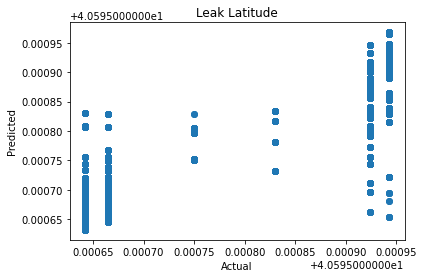

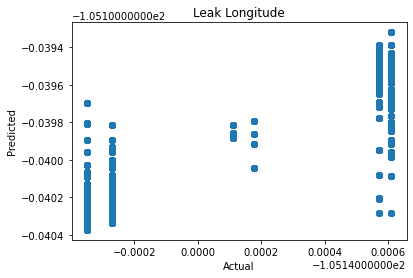

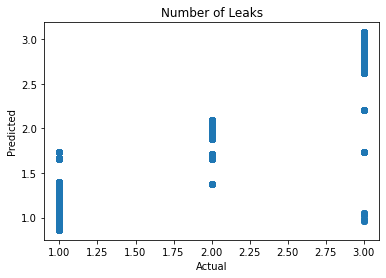

In [ ]:
# plot the actual vs predicted values
plt.scatter(y1_test, y1_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Leak Latitude")
plt.show()

plt.scatter(y2_test, y2_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Leak Longitude")
plt.show()

plt.scatter(y3_test, y3_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Number of Leaks")
plt.show()


